# CNN ARCHITECTURE

The prediction is made using an ensemble of 3 models. The final prediction is taken as an average of the predictions of the 3 models. This combination of models made the app more accurate.

## MODEL1

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 128
learning_rate = 0.001

# Load MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Split training data into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Epoch 1/7, Validation Loss: 0.1032, Validation Accuracy: 0.9698
Epoch 1/7, Training Loss: 0.3616
Epoch 2/7, Validation Loss: 0.0585, Validation Accuracy: 0.9821
Epoch 2/7, Training Loss: 0.0678
Epoch 3/7, Validation Loss: 0.0467, Validation Accuracy: 0.9860
Epoch 3/7, Training Loss: 0.0370
Epoch 4/7, Validation Loss: 0.0438, Validation Accuracy: 0.9871
Epoch 4/7, Training Loss: 0.0286
Epoch 5/7, Validation Loss: 0.0402, Validation Accuracy: 0.9880
Epoch 5/7, Training Loss: 0.0185
Epoch 6/7, Validation Loss: 0.0392, Validation Accuracy: 0.9881
Epoch 6/7, Training Loss: 0.0153
Epoch 7/7, Validation Loss: 0.0380, Validation Accuracy: 0.9888
Epoch 7/7, Training Loss: 0.0118
Test Accuracy: 0.9895


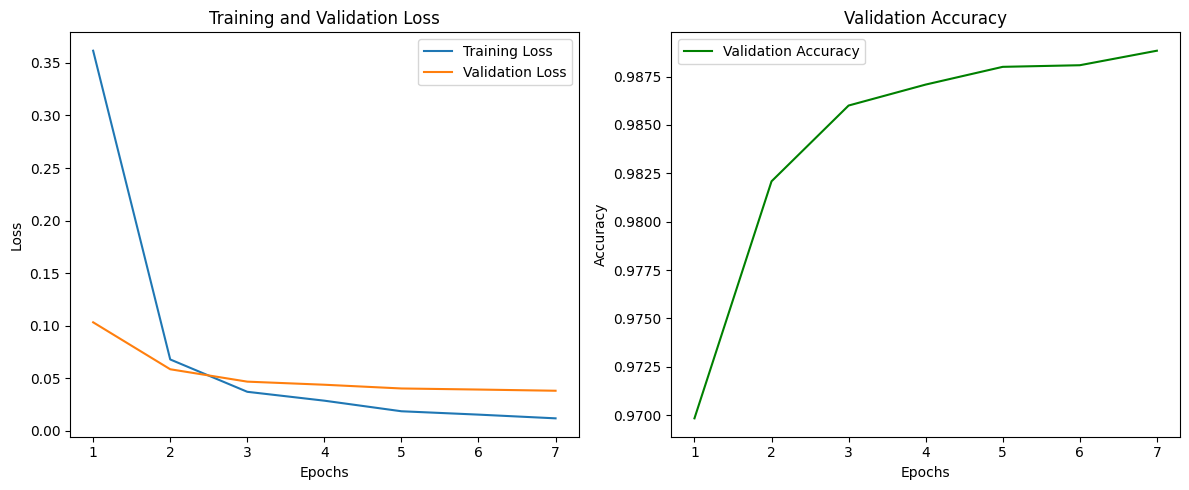

In [14]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64x28x28
        self.pool = nn.MaxPool2d(2, 2)  # Output after pooling: 64x14x14
        self.dropout1 = nn.Dropout(0.5)  # Dropout after convolutional layers
        self.fc1 = nn.Linear(64 * 14 * 14, 250)
        self.dropout2 = nn.Dropout(0.5)  # Dropout after first fully connected layer
        self.fc2 = nn.Linear(250, 10)
        # self.fc3 = nn.Linear(250, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 14 * 14)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        # x = self.fc3(x)
        return x



model = SimpleCNN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
num_epochs = 7

# Track metrics for visualization
train_losses = []
val_losses = []
val_accuracies = []

# Training function
def train_model():
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        validate_model(epoch)
        scheduler.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}")

# Validation function
def validate_model(epoch):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / len(val_dataset))
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

# Testing function
def test_model():
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_dataset)
    print(f"Test Accuracy: {accuracy:.4f}")

# Plot results
def plot_metrics():
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train, validate, and test the model
train_model()
test_model()
plot_metrics()

In [15]:
torch.save(model.state_dict(), 'simple_cnn.pth')